# Glued Trees Algorithm
### Introduction
Consider a network of two mirrored binary trees connected to each other, where the outermost nodes of each tree are connected to two random nodes in the other tree. This structure will have $2n$ columns and $2^{n+1}-2$ nodes in total, as shown in the diagram below. Each node in the structure has a secret key in the form of a random bit string of size $2n$, and you are given oracular access to the network such that you can query a node using its key to get the keys of its neighbors. Your goal is, given the key of the entrance node, to find the key of the exit node as efficiently as possible.

<center>
<img src="figures/glued_trees_diagram.png" style="width:80%">
<figcaption align = "middle">Example of a Glued Trees Structure</figcaption>
</center>

If you try to play this game yourself, or program an algorithm to do so, you'll quickly run into a major problem: since you don't know what specific nodes on the tree the interior keys correspond to, you will get lost within the structure once you reach the area between the two trees. There is no way to guarantee a solution to this problem—using a classical computer—that doesn't require you to check every node in the worst case.

There is a way to solve this problem efficiently however, on the order of the total number of *columns* of the structure instead of the nodes. You just need to use a quantum computer! This paper [[1](#GluedTrees)] published in December 2023 describes a quantum approach to solving this algorithm by considering the columns of the structure as a system of coupled harmonic oscillators attached by springs. A quantum computer can use Hamiltonian simulation to simulate this classical system efficiently. If you apply a push to the oscillator representing the entrance node, and treat the interactions between nodes as queries, you can "reach" the exit node (trigger a spike in its oscillatory movement) in time $2n$, offering linear efficiency as opposed to exponential efficiency!

While this notebook will be following the algorithm described by the 2023 paper above, it should be noted that this problem was first set by this paper from October 2002 [[2](#QuantumWalk)].

In [1]:
from typing import cast
from classiq import *
from classiq.execution import ExecutionPreferences
from qiskit.quantum_info import SparsePauliOp
from scipy import linalg
import numpy as np
import matplotlib.pyplot as plt
import json
%config InlineBackend.figure_format = 'retina' # improve graph image quality

### Quantum Algorithm
To model the columns of the glued trees structure as a system of coupled harmonic oscillators, we consider a weighted adjacency matrix $\mathbf{A}$ of size $2n \times 2n$ corresponding to the columns of the glued trees structure. As described in more detail in the paper linked above, this matrix is defined as the following:
$$
\mathbf{A} = \begin{bmatrix}
3 & -\sqrt{2} & 0 & 0 & 0 & 0 & \cdots & 0 \\
-\sqrt{2} & 3 & -\sqrt{2} & 0 & 0 & 0 & \cdots & \vdots\\
\vdots & \ddots & \ddots & \ddots & 0 & 0 & \cdots & \vdots \\
0 & \cdots & -\sqrt{2} & 3 & -2 & \cdots & 0 & 0 \\
0 & 0 & \cdots & -2 & 3 & -\sqrt{2} & \cdots & 0 \\
\vdots & \cdots & 0 & 0 & \ddots & \ddots & \ddots & \vdots \\
\vdots & \cdots & 0 & 0 & 0 & -\sqrt{2} & 3 & -\sqrt{2} \\
0 & \cdots & 0 & 0 & 0 & 0 & -\sqrt{2} & 3
\end{bmatrix}
$$

The key to the quantum advantage present in this problem is present in the fact that this weighted adjacency matrix is modeling the *columns* of the system as opposed to the nodes; this means that the matrix can be small and uniform instead of needing to worry about the large array of random connections in between the two trees. Additionally, it means that a quantum computer can model very large cases of the problem with a relatively small number of qubits.

We can observe the following relation, where $\vec{z}(t)$ represents the vector of size $2n$ of position states for each oscillator:
$$
\begin{aligned}
\ddot{\vec{z}}(t) &= -\mathbf{A}\vec{z}(t) \\
\ddot{\vec{z}}(t) + i\sqrt{\mathbf{A}}\dot{\vec{z}}(t) &= i\sqrt{\mathbf{A}}\big(\dot{\vec{z}}(t)+i\sqrt{\mathbf{A}}\vec{z}(t)\big)
\end{aligned}
$$

This is equivalent to Schrödinger's equation induced by the Hamiltonian $-\sqrt{\mathbf{A}}$. Therefore, this system of oscillators can be modeled by the exponentiation $\exp(-iHt)$ where $H=-\sqrt{\mathbf{A}}$.

The following code segments contain all of the helper methods that relate to creating the matrix $-\sqrt{\mathbf{A}}$ and processing it in a form that Classiq's `exponentiation_with_depth_constraint` function can understand.

The `pauli_str_to_enums` and `pauli_list_to_hamiltonian` functions are taken from the Classiq documentation and convert the list of tuples input into a `PauliTerm` list, the input Classiq recognizes for its exponentiation function.

In [2]:
CHAR_TO_STUCT_DICT = {"I": Pauli.I, "X": Pauli.X, "Y": Pauli.Y, "Z": Pauli.Z}

def pauli_str_to_enums(pauli):
    return [CHAR_TO_STUCT_DICT[s] for s in pauli]

def pauli_list_to_hamiltonian(pauli_list):
    return [
        PauliTerm(
            pauli=pauli_str_to_enums(pauli), coefficient=cast(complex, coeff).real
        )
        for pauli, coeff in pauli_list
    ]

All Pauli list outputs are cropped so they have no more than 200 terms. This is to ensure that the circuit depth is at a reasonable range (low thousands) given the limits of current quantum hardware. As a result of this approach, as the number of qubits increases, the accuracy of the Pauli list in comparison to the matrix it represents diminishes so the circuit depth remains roughly constant.

The Pauli list representation of $-\sqrt{\mathbf{A}}$ for qubit values small enough to calculate (13 qubits and lower) are generated and cropped using the `generate_pauli_list` function, which uses an ad hoc approach that tries to represent the Pauli list as a whole as accurately as possible using only the 200 ostensibly most relevant terms to simulating the system. Before the cropping algorithm is applied, the full Pauli list is generated using Qiskit's `SparsePauliOp.from_operator` [[3](#SparsePauliOp)] function. 

The cropping algorithm, defined in the `crop_pauli_list` function, first selects 120 terms (60%) by going through each character position from the end to the start and picking the Pauli terms with the largest coefficients that contain each of the four possibilities ($I$, $X$, $Y$, $Z$) at that character position. If all positions are exhausted before reaching 120 terms, the algorithm takes another pass through the character positions until 120 are selected. The other 80 terms (40%) are selected by picking the 80 remaining terms with the largest coefficients. The algorithm balances important high-coefficient terms with diversity in the 200 selected terms.

The Pauli lists for qubit values too large to fully calculate (greater than 13 qubits) are approximated by padding with the first character of the Pauli strings of the largest cropped Pauli list that can be generated in reasonable time.

In [3]:
def crop_pauli_list(pauli, size):
    if len(pauli) <= size:
        return pauli
    result = []
    idx = 0
    while len(result) < round(size*0.6):
        for i in range(len(pauli[0][0])-1, -1, -1):
            for k in pauli:
                if k[0][i] == 'IXYZ'[idx%4] and k not in result:
                    result.append(k)
                    break
            idx += 1
    for i in pauli:
        if len(result) >= size:
            break
        if i not in result:
            result.append(i)
    return result

def generate_pauli_list(dim):
    A = [[0] * 2**dim for _ in range(2**dim)]
    for i in range(2**dim):
        if i >= 1:
            A[i][i-1] = -2 if i == 2**(dim-1) else -np.sqrt(2)
        A[i][i] = 3
        if i < 2**dim-1:
            A[i][i+1] = -2 if i == 2**(dim-1)-1 else -np.sqrt(2)
    A_sqrt = -np.array(linalg.sqrtm(A))
    c = SparsePauliOp.from_operator(A_sqrt)
    result = [(str(c.paulis[i]), c.coeffs[i].real) for i in range(len(c))]
    return crop_pauli_list(sorted(result, key=lambda x: abs(x[1]), reverse=True), 200)

def pauli_str(dim):
    if dim > 13:
        return [(i[0][0]*(dim-len(i[0]))+i[0], i[1]) for i in generate_pauli_list(13)]
    return generate_pauli_list(dim)

As a preliminary test, we begin by using the `n_oscillators` function to simulate our Hamiltonian represented by Pauli strings of length `dim` from $t=0$ to $t=$`maxim` in `step` intervals. The `add_point` inner function is called repeatedly to simulate exponentiation using Classiq's Aer simulator for different time values. The output is a plot of the shots of the state representing the exit column oscillator $|{2^q-1}\rangle$ where $q$ is the number of qubits, `dim`.

Since the Pauli strings will be of length $q$, the matrix $\mathbf{A}$ must be of size $2^q \times 2^q$. Since we know that $\mathbf{A}$ is also of size $2n \times 2n$, the relationship $n=2^{q-1}$ is formed. This means that the state representing the exit column oscillator can also be thought of as $|2n-1\rangle$.

In [4]:
def n_oscillators(dim, maxim, step):
    pauli_list = pauli_str(dim)
    def add_point(t):
        @qfunc
        def main(state: Output[QArray[QBit]]) -> None:
            allocate(len(pauli_list[0][0]), state)
            exponentiation_with_depth_constraint(
                pauli_operator=pauli_list_to_hamiltonian(pauli_list),
                evolution_coefficient=CReal(str(t)),
                max_depth=2000,
                qbv=state,
            )
        execution_preferences = ExecutionPreferences(num_shots=4096)
        model = set_execution_preferences(create_model(main), execution_preferences)
        quantum_program = synthesize(model)
        job = execute(quantum_program)
        results = job.result()
        return results[0].value
    times = np.arange(0, maxim, step)
    output = []
    for t in times:
        point = add_point(t)
        try:
            index = [idx for idx, s in enumerate(point.parsed_counts) if str(2**dim-1)+'.0' in str(s)][0]
            output.append(point.parsed_counts[index].shots/point.num_shots)
        except IndexError:
            output.append(0)
    plt.plot(times, output)
    plt.xlabel("Time (s)")
    plt.ylabel("Proportion of |"+str(2**dim-1)+"> shots")
    plt.show()

This is an example of the `n_oscillators` function, simulating the proportion of $|7\rangle$ shots for 3 qubits ($n=4$) from $t=0$ to $t=16$ in 1 second intervals. The important thing to note is that there is a spike at $t \approx 2n=8$. A spike should be expected for all states laggingly, starting with $|0\rangle$ at $t \approx 0$, as the initial push of the first oscillator in the system of coupled harmonic oscillators propagates throughout the system until it reaches the last oscillator.

This instance of the function should take approximately 90 seconds to run.

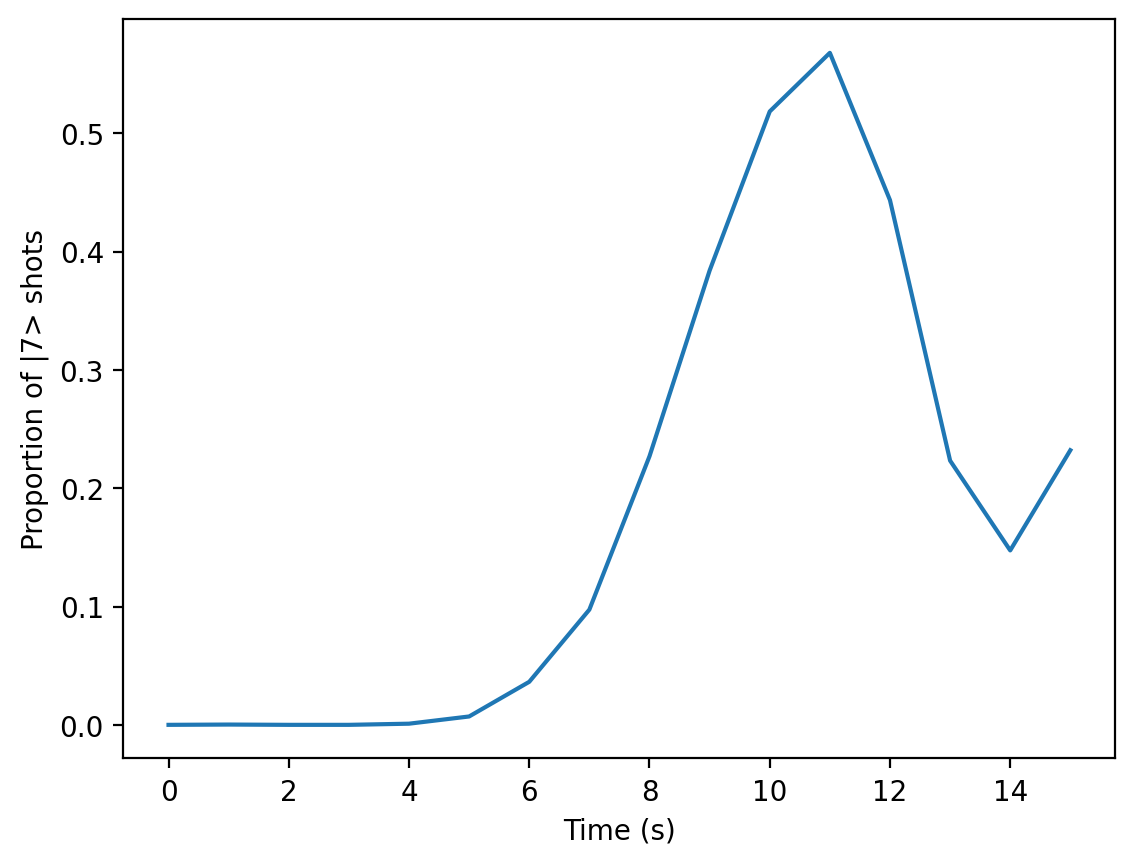

In [5]:
n_oscillators(3, 16, 1)

We are now ready to run our main execution function, `run_point`. This function takes in the number of qubits `dim` and the time `t` to perform Hamiltonian simulation $\exp(-iHt)$ where $H=-\sqrt{\mathbf{A}}$ using the `exponentiation_with_depth_constraint` function in the Classiq software development kit. 

The `max_depth` parameter is set to 1300, which is around the range of the current limit for comprehensible results in state of the art quantum computers. The `num_shots` parameter is set to 8192 to give enough of room for significant spikes in a state to be apparent given the high number of total possible states.

We will run the `run_point` function through a helper function `run_range`, which executes it 9 times in total for a given qubit size, spanning from $t=2n-40$ to $t=2n+40$ in 10 second intervals. This range gives time to observe oscillation occurring at high state values while also being close enough around $t=2n$, the time where we are expecting some spike in high states.

In [6]:
def run_point(dim, t, pauli_list):
    @qfunc
    def main(state: Output[QArray[QBit]]) -> None:
        allocate(len(pauli_list[0][0]), state)
        exponentiation_with_depth_constraint(
            pauli_list_to_hamiltonian(pauli_list),
            evolution_coefficient=t,
            max_depth=1300,
            qbv=state,
        )
    execution_preferences = ExecutionPreferences(num_shots=8192)
    model = set_execution_preferences(create_model(main), execution_preferences)
    quantum_program = synthesize(model)
    job = execute(quantum_program)
    filename = str(dim)+'-qubits/2n'+(str(t-2**dim) if t < 2**dim else '+'+str(t-2**dim))
    json.dump(dict(job.result()[0].value), open('results/'+filename+'.json', 'w'))

def run_range(dim):
    pauli_list = pauli_str(dim)
    for i in range(-40, 50, 10):
        run_point(dim, 2**dim+i, pauli_list)

The following code segment displays the execution of `run_range` for 10 qubits ($n=512$), a higher qubit value that is still simulatable. In addition, it is low enough that its Pauli list can still be fully generated and cropped.

This instance of the function should take approximately 90 seconds to run.

In [7]:
run_range(10)

The following code segment, on the other hand, displays the execution of `run_range` for 20 qubits ($n=524288$), a qubit value that is still simulatable but where its Pauli list cannot be generated and is thus approximated using the Pauli list for 13 qubits.

Since this instance of the function requires generating the Pauli list for 13 qubits, which is very large, it will take up to 10 minutes to run. Feel free to uncomment the line of code if you would like to try running it.

Alternatively, you can view the `qmod` file for the execution of `run_point` for 20 qubits at $t=2n$, which has been saved in this directory as `glued_trees_example.qmod`.

In [8]:
#run_range(20)

We can now graph the results we have generated using the simulator, which have been saved into directories in the `results` folder based on their qubit size. The `graph_results` function creates a stackplot of the proportion of shots for the 8 highest possible bitstrings for a given qubit value from $t=2n-40$ to $t=2n+40$ and saves it in the `figures` folder. 

The reason we use the 8 largest bitstrings is because all of them are expected to have a spike within this range (from $t \approx 2n-16$ to $t \approx 2n$) and due to the large number of oscillators the system is modeling, the trend is easier to see with multiple qubit states.

In [9]:
def graph_results(dim):
    states = ['-40', '-30', '-20', '-10', '+0', '+10', '+20', '+30', '+40']
    times = [2**dim+int(i) for i in states]
    data = {}
    for i in states:
        with open('results/'+str(dim)+'-qubits'+'/2n'+i+'.json', 'r') as f:
            j = json.load(f)
            counts = dict([i for i in j['counts'].items() if i[0][:-3] == '1'*(dim-3)])
            for k in range(8):
                key = '1'*(dim-3)+bin(k)[2:].rjust(3, '0')
                if key not in data:
                    data[key] = []
                data[key].append(counts[key]/j['num_shots'] if key in counts else 0)
    plt.stackplot(times, np.array(list(data.values())), labels=['1...1'+i[-3:] for i in data.keys()])
    plt.legend(loc='upper left')
    plt.xlabel('Time (s)')
    plt.ylabel('Proportion of Shots')
    plt.title(r'Glued Trees System at $t \approx 2n$ for '+str(dim)+' Qubits')
    plt.savefig('figures/'+str(dim)+'_qubits.png', bbox_inches='tight', dpi=300)
    plt.show()

The following code segment displays the graph for 10 qubits, a qubit size with a generated and cropped Pauli list. As expected, there is a large spike in the highest bitstrings at $t \approx 2n$, in this case slightly after $t=2n$.

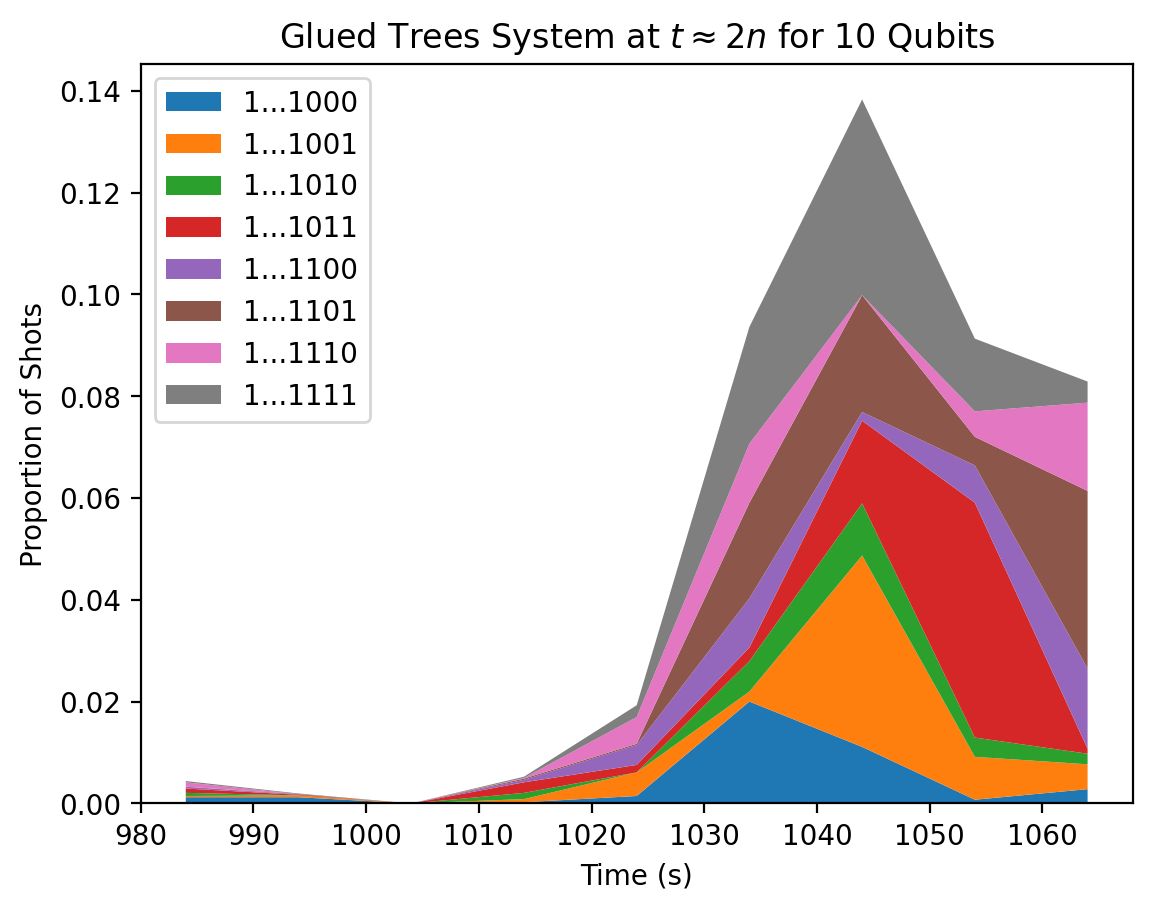

In [10]:
graph_results(10)

The following code segment displays the graph for 20 qubits, a qubit size with an approximated Pauli list. The spike here at $t \approx 2n$ happens to be slightly before $t=2n$ and is apparent for all 8 of the highest bitstrings.

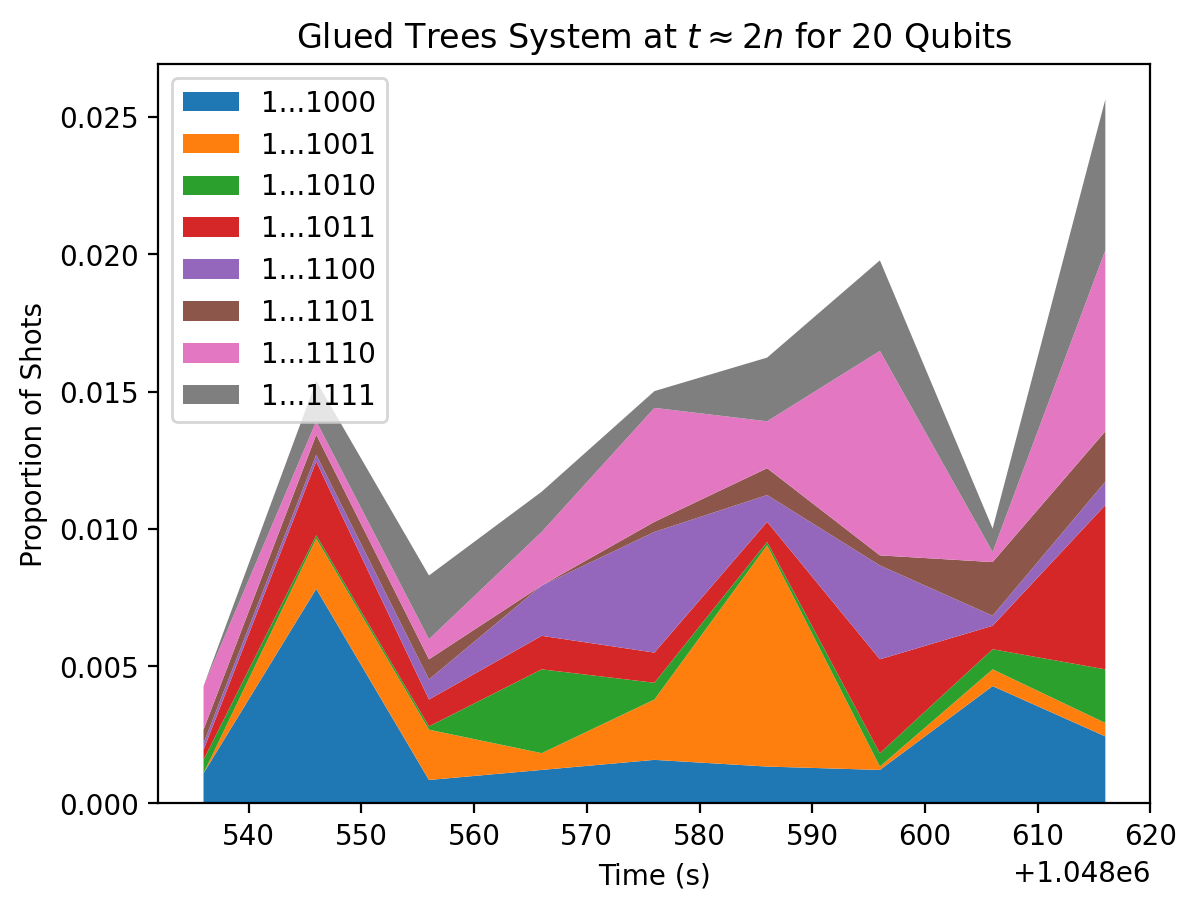

In [11]:
graph_results(20)

Because of our Pauli list cropping, the algorithm can also be run with reasonable accuracy on actual quantum hardware. Simply add one of Classiq's quantum hardware [cloud providers](https://docs.classiq.io/latest/reference-manual/platform/executor/cloud-providers/) as an execution preference in the `run_point` function.

Perhaps the most interesting thing about the glued trees algorithm is that it is a relatively heavy case of using a quantum computer to gain an exponential advantage, usually requiring several executions at different time points to observe the intended result, but it can still be executed effectively on present-day quantum hardware due to the Pauli list cropping. I encourage you to try out the algorithm on both a simulator and quantum hardware for various qubit sizes! 

### References
<a id="GluedTrees">[1]</a>: [Babbush, Ryan and Berry, Dominic W. and Kothari, Robin and Somma, Rolando D. and Wiebe, Nathan. "Exponential Quantum Speedup in Simulating Coupled Classical Oscillators." Phys. Rev. X 13, 041041 (2023)](https://journals.aps.org/prx/pdf/10.1103/PhysRevX.13.041041)

<a id="QuantumWalk">[2]</a>: [Childs, Andrew M. and Cleve, Richard and Deotto, Enrico and Farhi, Edward and Gutmann, Sam and Spielman, Daniel A. "Exponential algorithmic speedup by a quantum walk." Proc. 35th ACM Symposium on Theory of Computing (STOC 2003), pp. 59-68](https://arxiv.org/pdf/quant-ph/0209131)

<a id="SparsePauliOp">[3]</a>: [SparsePauliOp (Qiskit)](https://docs.quantum.ibm.com/api/qiskit/qiskit.quantum_info.SparsePauliOp)